In [104]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tectosaur.mesh.mesh_gen

from scipy.integrate import RK45
from scipy.optimize import fsolve

import cutde.fullspace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.environ['CUDA_DEVICE'] = '0'

In [90]:

qd_cfg = dict(
    # Material properties
    sm = 3e10,          # Shear modulus (Pa)
    pr = 0.25,          # Poisson ratio 
    density = 2700,     # rock density (kg/m^3)

    # Frictional properties
    Dc = 0.02,         # state evolution length scale (m)
    f0 = 0.6,           # baseline coefficient of friction
    V0 = 1e-6,          # when V = V0, f = f0, V is (m/s)

    # Boundary conditions
    plate_rate = 1e-9,  # (m/s), equivalent to ~31.5 mm/yr
    
    # This is only necessary because this is a full space model and there's no concept of depth or gravity
    additional_normal_stress = 50e6, 
)
qd_cfg['cs'] = np.sqrt(qd_cfg['sm'] / qd_cfg['density'])# Shear wave speed (m/s)
qd_cfg['eta'] = qd_cfg['sm'] / (2 * qd_cfg['cs'])       # The radiation damping coefficient (kg / (m^2 * s))

In [91]:
def dofs_to_tris(field, factor = 3):
    n_rects = field.shape[0]
    out = np.tile(field.reshape((n_rects, -1))[:,np.newaxis,:], (1,factor,1))
    out_shape = list(field.shape)
    out_shape[0] *= factor
    return out.reshape(out_shape)

def rect_points(corners, xhat_vals, yhat_vals):
    nx = xhat_vals.shape[0]
    ny = yhat_vals.shape[0]
    corners = np.array(corners)

    rect_basis = [
        lambda x, y: x * y,
        lambda x, y: (1 - x) * y,
        lambda x, y: (1 - x) * (1 - y),
        lambda x, y: x * (1 - y)
    ]

    X, Y = np.meshgrid(xhat_vals, yhat_vals)
    vertices = np.vstack((X.reshape(nx * ny), Y.reshape(nx * ny))).T

    pts = np.sum([
        np.outer(rect_basis[i](vertices[:,0], vertices[:,1]), corners[i, :])
        for i in range(4)
    ], axis = 0)
    return pts

def build_weird_tri_mesh(nx, ny, corners):
    true_nx = 2 * nx - 1
    x = np.linspace(0, 1, 2 * nx - 1)
    y = np.linspace(0, 1, ny)
    pts = rect_points(corners, x, y)

    def v_idx(i, j):
        return j * true_nx + i * 2

    def midpt_idx(i, j):
        return j * true_nx + i * 2 + 1

    tris = []
    rects = []
    for i in range(nx - 1):
        for j in range(ny - 1):
            top_left = v_idx(i, j)
            top_right = v_idx(i + 1, j)
            bottom_left = v_idx(i, j + 1)
            bottom_right = v_idx(i + 1, j + 1)
            top_middle = midpt_idx(i, j)
            tris.append([top_left, bottom_left, top_middle])
            tris.append([top_middle, bottom_right, top_right])
            tris.append([bottom_left, bottom_right, top_middle])
            rects.append([top_left, bottom_left, bottom_right, top_right])
    tris = np.array(tris, dtype = np.int)
    rects = np.array(rects, dtype = np.int)
    return pts, tris, rects

In [98]:
W = 7500
w = 15000
fL = W + w
fW = 2 * W + w
corners = [
    [-fL, 0, 0], [-fL, 0, -fW],
    [fL, 0, -fW], [fL, 0, 0]
]
n_el_y = 10
n_el_x = int(1.5  * n_el_y)
pts, tris, rects = build_weird_tri_mesh(n_el_y + 1, n_el_x + 1, corners)

n_tris = tris.shape[0]
n_rects = rects.shape[0]
assert(n_el_x * n_el_y == n_rects)
tri_pts = pts[tris]
rect_pts = pts[rects]
rect_centers = np.mean(rect_pts, axis = 1)

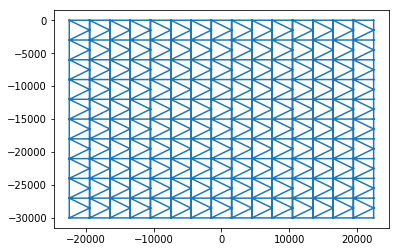

In [127]:
plt.triplot(pts[:,0], pts[:,2], tris)
plt.show()

In [99]:
# x_lims = np.logical_and(dof_pts[:,0] < 15000, dof_pts[:,0] > -15000)
# y_lims = np.logical_and(dof_pts[:,1] < 7500, dof_pts[:,1] > -7500)
# interior = np.logical_and(x_lims, y_lims)

def B(x, W, w):
    out = 0.5 * (1 + np.tanh((w / (np.abs(x) - W - w)) + (w / (np.abs(x) - W))))
    out[np.abs(x) <= W] = 1.0
    out[np.abs(x) >= W + w] = 0.0
    return out

delta_a0 = 0.008
y0 = -fW / 2.0
delta_a = delta_a0 * (1 - B(rect_centers[:,0], W, w) * B(rect_centers[:,2] - y0, W / 2.0, w))
a = 0.015 + delta_a
b = np.ones_like(a) * 0.021
qd_cfg['a'] = a
qd_cfg['b'] = b
#plot_fields(, np.vstack((qd_cfg['a'], qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'] < 0)).T)

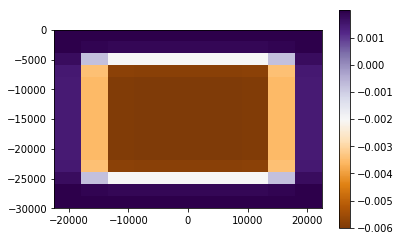

In [100]:
extents = (np.min(pts[:,0]), np.max(pts[:,0]), np.min(pts[:,2]), np.max(pts[:,2]))
def plot_field(f, **kwargs):
    plt.imshow(f.reshape(n_el_y, n_el_x).T, extent = extents, cmap = 'PuOr', **kwargs)
    plt.colorbar()
    plt.show()
plot_field(a-b)

In [101]:
mesh_L = (extents[1] - extents[0]) / n_el_x
Lb = qd_cfg['sm'] * qd_cfg['Dc'] / (qd_cfg['additional_normal_stress'] * qd_cfg['b'])
hstar = (np.pi * qd_cfg['sm'] * qd_cfg['Dc']) / (qd_cfg['additional_normal_stress'] * (qd_cfg['b'] - qd_cfg['a']))

hstarRA = (2.0 / np.pi) * qd_cfg['sm'] * qd_cfg['b'] * qd_cfg['Dc'] / ((qd_cfg['b'] - qd_cfg['a']) ** 2 * qd_cfg['additional_normal_stress'])
hstarRA3D = np.pi ** 2 / 4.0 * hstarRA
# all_fields = np.vstack((Lb, hstar, np.ones_like(hstar) * mesh_L)).T
# plot_fields(qdm.m, all_fields)
print('hstar (2d antiplane, erickson and dunham 2014)', np.min(np.abs(hstar)))
print('hstar_RA (2d antiplane, rubin and ampuero 2005)', np.min(np.abs(hstarRA)))
print('hstar_RA3D (3d strike slip, lapusta and liu 2009)', np.min(np.abs(hstarRA3D)))
print('cohesive zone length scale', np.min(Lb))
print('mesh length scale', mesh_L)

hstar (2d antiplane, erickson and dunham 2014) 6283.185307179584
hstar_RA (2d antiplane, rubin and ampuero 2005) 4456.338406573068
hstar_RA3D (3d strike slip, lapusta and liu 2009) 10995.574287564272
cohesive zone length scale 571.4285714285714
mesh length scale 3000.0


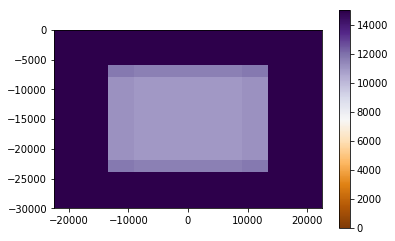

In [102]:
plot_field(hstarRA3D, vmin = 0.0, vmax = 15000.0)

In [131]:
matrix = np.empty((n_rects, 3, n_rects))
tris_ones = np.zeros((tri_pts.shape[0],3))
tris_ones[:,0] = 1.0 # only strike slip motion
for i in range(n_rects):
    obs_pts = np.tile(rect_centers[i,np.newaxis,:], (n_tris, 1)).copy()
    strains = cutde.fullspace.clu_strain(obs_pts, tri_pts, tris_ones, qd_cfg['pr'])
    stresses = cutde.fullspace.strain_to_stress(strains, qd_cfg['sm'], qd_cfg['pr'])
traction = [stresses[:, stresses[:, 1]

array([  0.        ,   0.        ,   0.        , -60.62393605,   0.        ,  19.35948666])

In [7]:
def get_slip_to_traction(qdm, qd_cfg):
    def slip_to_traction(slip):
        strain = np.empty((n_rects, 6))
        for i in range(n_rects):
            obs_pts = np.tile(rect_centers[i,np.newaxis,:], (n_tris, 1))
            all_strains = cutde.fullspace.clu_strain(obs_pts, tri_pts, slip_tris, nu)
            strain[i, :] = np.sum(all_strains, axis = 0)
        stress = cutde.fullspace.strain_to_stress(strain, sm, nu)



def separate_slip_state(y):
    n_total_dofs = y.shape[0]
    n_slip_dofs = n_total_dofs // 4 * 3
    return y[:n_slip_dofs], y[n_slip_dofs:]

def get_plate_motion(qdm, qd_cfg, t):
    return t * qd_cfg['plate_rate'] * qdm.field_100

def get_slip_deficit(qdm, qd_cfg, t, slip):
    out = qdm.ones_interior * (get_plate_motion(qdm, qd_cfg, t).reshape(-1) - slip)
    #np.testing.assert_almost_equal(qdm.field_100_edges * out, 0.0)
    return out

def rate_state_solve(qdm, qd_cfg, traction, state):
    V = np.empty_like(qdm.field_100)
    qd_newton.rate_state_solver(
        qdm.tri_normals, traction, state, V,
        qd_cfg['a'], qd_cfg['eta'], qd_cfg['V0'],
        qd_cfg['additional_normal_stress'],
        1e-12, 50
    )
    out_V = qdm.field_100_edges * qd_cfg['plate_rate'] + qdm.ones_interior * V
    return out_V
    #     out_V = out_V.reshape((-1,3,3))
#     pt_V = np.zeros(qdm.m.pts.shape)
#     pt_n = np.zeros(qdm.m.pts.shape[0])
#     for i in range(qdm.m.tris.shape[0]):
#         pt_V[qdm.m.tris[i]] += out_V[i]
#         pt_n[qdm.m.tris[i]] += 1
#     pt_V /= pt_n[:,np.newaxis]
#     final_V = np.empty_like(out_V)
#     for i in range(qdm.m.tris.shape[0]):
#         final_V[i] = pt_V[qdm.m.tris[i]]
#     return final_V.reshape(-1)

# State evolution law -- aging law.
def aging_law(qd_cfg, V, state):
    return (qd_cfg['b'] * qd_cfg['V0'] / qd_cfg['Dc']) * (
        np.exp((qd_cfg['f0'] - state) / qd_cfg['b']) - (V / qd_cfg['V0'])
    )

def state_evolution(qdm, qd_cfg, V, state):
    V_mag = np.linalg.norm(V.reshape(-1,3), axis = 1)
    qdm.max_V = np.max(V_mag)
    return aging_law(qd_cfg, V_mag, state)

def solve_for_full_state(qdm, qd_cfg, slip_to_traction, t, y):
    tm = Timer()
    slip, state = separate_slip_state(y)
    tm.report('sep')
    slip_deficit = get_slip_deficit(qdm, qd_cfg, t, slip)
    tm.report('slip deficit')

    traction = slip_to_traction(slip_deficit)
    tm.report('slip_to_traction')
    V = rate_state_solve(qdm, qd_cfg, traction, state)
    tm.report('rate_state_solve')
    dstatedt = state_evolution(qdm, qd_cfg, V, state)
    tm.report('state_evolution')
    return slip, slip_deficit, state, traction, V, dstatedt

def make_qd_derivs(qdm, qd_cfg, slip_to_traction):
    def qd_derivs(t, y):
        slip, slip_deficit, state, traction, V, dstatedt = solve_for_full_state(
            qdm, qd_cfg, slip_to_traction, t, y
        )
        #print('Vmax', np.max(V.reshape((-1,3)), axis = 0))
        #TODO: CHECK THE DIMENSIONS ON V AND dstatedt
        return np.concatenate((V, dstatedt))
    return qd_derivs

def plot_setting(t, y, qdm, qd_cfg, slip_to_traction):
    slip, slip_deficit, state, traction, V, dstatedt = solve_for_full_state(
        qdm, qd_cfg, slip_to_traction, t, y
    )
    #print('slip')
    #plot_signs(slip)
    #plot_fields(np.log10(np.abs(slip) + 1e-40))
    #print('deficit')
    #plot_signs(slip_deficit)
    #plot_fields(np.log10(np.abs(slip_deficit) + 1e-40))
    print('slip')
    plot_fields(qdm.m, slip)
    print('V')
    #plot_signs(V)
    plot_fields(qdm.m, np.log10(np.abs(V) + 1e-40))
    print('traction')
    min_trac = 0.9 * np.max(traction)
    max_trac = np.max(traction)
    plot_fields(qdm.m, traction, levels = np.linspace(min_trac, max_trac, 20))
    print('state')
    plot_fields(qdm.m, state)

In [8]:
traction_to_slip = get_traction_to_slip(qdm, qd_cfg)
slip_to_traction = get_slip_to_traction(qdm, qd_cfg)

[63858:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 2


In [9]:
derivs = make_qd_derivs(qdm, qd_cfg, slip_to_traction)

In [10]:
# initial_stress = -qdm.field_100_interior * qd_cfg['f0'] * sigma_n
# initial_stress.reshape((-1,3))[np.logical_and(dof_pts[:,0] > -15000, dof_pts[:,0] < -0), 0] *= 1.1
# #initial_stress = qdm.field_100_interior
# initial_slip = traction_to_slip(initial_stress)
# plot_fields(qdm.m, initial_slip)

# reverse = slip_to_traction(initial_slip)
# plot_fields(qdm.m, initial_slip)
# plot_fields(qdm.m, initial_stress)
# plot_fields(qdm.m, reverse)
# plot_fields(qdm.m, reverse - initial_stress)
# NS = traction_to_slip((reverse - initial_stress))
# plot_fields(qdm.m, NS)

# A = slip_to_traction(initial_slip + NS)
# B = slip_to_traction(initial_slip)
# C = slip_to_traction(NS)
# plot_fields(qdm.m, A)
# plot_fields(qdm.m, B)
# plot_fields(qdm.m, C)

# initial_stress_mag = np.linalg.norm(initial_stress.reshape((-1,3)), axis = 1)

# initial_vel = qd_cfg['V0'] * np.exp((1 / (qd_cfg['a'] - qd_cfg['b'])) * (initial_stress_mag / sigma_n - qd_cfg['f0']))
# initial_state = np.ones_like(initial_vel) * 0.6#qd_cfg['f0'] - qd_cfg['b'] * np.log(initial_vel / qd_cfg['V0'])
# plot_fields(qdm.m, np.log10(np.abs(initial_vel) + 1e-40))
# plot_fields(qdm.m, initial_state)

# qd_cfg['constant_traction_slip'] = traction_to_slip(qdm.field_100)
# plot_fields(qdm.m, qd_cfg['constant_traction_slip'] )

# Setup the (slip -> traction) operator

# Set up initial conditions. The edges of the fault should move at the plate rate and the interior should be moving at 1/1000th the plate rate. Then, solve for the corresponding steady state.

# plot_fields(qdm.m, initial_slip)
# plot_fields(qdm.m, initial_state)

In [11]:
initial_slip = np.zeros(qdm.m.tris.shape[0] * 9)
initial_state = 0.8 * np.ones(qdm.m.tris.shape[0] * 3)
initial_conditions = np.concatenate((initial_slip, initial_state))
initial_time = 0.0
# ts, initial_conditions = np.load('initialconditions.npy')
# initial_time = ts[-1]
integrator = RK45(derivs, initial_time, initial_conditions, 1e20, atol = 1e-5, rtol = 1e-5)

In [12]:
# t = integrator.t
# y = integrator.y
# slip, state = separate_slip_state(y)
# slip_deficit = get_slip_deficit(qdm, qd_cfg, t, slip)
# traction = slip_to_traction(slip_deficit)
# V = rate_state_solve(qdm, qd_cfg, traction, state)
# dstatedt = state_evolution(qdm, qd_cfg, V, state)
# # plot_fields(qdm.m, slip)
# # plot_fields(qdm.m, slip_deficit)
# # plot_fields(qdm.m, traction)
# plot_fields(qdm.m, np.log10(np.abs(V) + 1e-40))
# plot_fields(qdm.m, dstatedt)

In [ ]:
from tectosaur.util.timer import Timer
h_t = []
h_y = []
siay = 60 * 60 * 24 * 365.25
for i in range(500):
    assert(integrator.step() == None)
    h_t.append(integrator.t)
    h_y.append(integrator.y.copy())
    print(i, integrator.t / siay)
    if len(h_t) > 1:
        dt = h_t[-1] - h_t[-2]
        dx = fL / n_fault
        dt_dynamic = mesh_L / qd_cfg['cs'] / 3.0
        dt_evol = 0.5 * qd_cfg['Dc'] / qdm.max_V
        print('time step vs lapusta', dt, dt_evol, dt_dynamic)
#     if i % 1 == 0:
#         plot_setting(integrator.t, integrator.y, qdm, qd_cfg, slip_to_traction)
    #if i % 5 == 0:
np.save('results.npy', np.array([qdm.m, qd_cfg, h_t, h_y], dtype = np.object))

0 8.89684966688e-08
1 9.78653463357e-07
time step vs lapusta 28.0763223048 500000.0 0.00970672856577
2 9.87550313024e-06
time step vs lapusta 280.763223048 500000.0 0.00970672856577
3 9.8843999799e-05
time step vs lapusta 2807.63223048 500000.0 0.00970672856577
4 0.000988528966487
time step vs lapusta 28076.3223048 500000.0 0.00970672856577
5 0.00988537863337
time step vs lapusta 280763.223048 500000.0 0.00970672856577
6 0.0988538753022
time step vs lapusta 2807632.23048 500000.0 0.00970672856577


/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in exp
/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:141: RuntimeWarning: invalid value encountered in true_divide
  error_norm = norm(error / scale)


7 0.12932127635
time step vs lapusta 961478.055307 500000.0 0.00970672856577
8 0.176702633863
time step vs lapusta 1495241.92786 500000.0 0.00970672856577
9 0.251801123138
time step vs lapusta 2369928.08515 500000.0 0.00970672856577
10 0.334465421005
time step vs lapusta 2608686.84636 500000.0 0.00970672856577
11 0.449833646797
time step vs lapusta 3640744.32225 500000.0 0.00970672856577
12 0.555598186965
time step vs lapusta 3337675.05282 500000.0 0.00970672856577
13 0.662505830318
time step vs lapusta 3373748.64587 500000.0 0.00970672856577
14 0.761063648258
time step vs lapusta 3110248.19541 500000.0 0.00970672856577
15 0.866456810725
time step vs lapusta 3325955.26388 500000.0 0.00970672856577
16 0.96047693628
time step vs lapusta 2967049.5142 500000.0 0.00970672856577
17 1.06012505765
time step vs lapusta 3144655.555 500000.0 0.00970672856577
18 1.11443374505
time step vs lapusta 1713851.83348 500000.0 0.00970672856577


/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:141: RuntimeWarning: overflow encountered in true_divide
  error_norm = norm(error / scale)


19 1.12865578617
time step vs lapusta 448813.484937 362713.160351 0.00970672856577
20 1.15082859985
time step vs lapusta 699720.784952 201546.230134 0.00970672856577
21 1.17895203156
time step vs lapusta 887508.008463 141693.57751 0.00970672856577
22 1.19256486899
time step vs lapusta 429588.478486 132500.203521 0.00970672856577
23 1.21052614158
time step vs lapusta 566814.655827 119663.43097 0.00970672856577
24 1.23061700512
time step vs lapusta 634019.43542 103371.946153 0.00970672856577
25 1.24424012282
time step vs lapusta 429912.898866 94780.6435288 0.00970672856577
26 1.25789666065
time step vs lapusta 430967.558372 86212.6458316 0.00970672856577
27 1.26895943699
time step vs lapusta 349114.670524 132857.960649 0.00970672856577
28 1.28101930134
time step vs lapusta 380580.375333 128076.37642 0.00970672856577
29 1.29540233896
time step vs lapusta 453894.147832 125912.992482 0.00970672856577
30 1.31779161027
time step vs lapusta 706551.668439 134269.022784 0.00970672856577
31 1.324

In [ ]:
# t = integrator.t
# slip, state = separate_slip_state(integrator.y)
# # slip[:] = qdm.slip100_edges
# # t = 1.0 * siay
# plate_motion = get_plate_motion(qdm, qd_cfg, t)
# slip_deficit = get_slip_deficit(qdm, qd_cfg, t, slip)
# traction = slip_to_traction(slip_deficit)
# V = rate_state_solve(qdm, qd_cfg, traction, state)
# dstatedt = state_evolution(qd_cfg, V, state)

# plot_fields(qdm.m, slip)

# V_mag = np.linalg.norm(V.reshape(-1,3), axis = 1)
# ss = qd_cfg['f0'] - qd_cfg['b'] * np.log(V_mag / qd_cfg['V0'])
# plot_fields(qdm.m, ss)
# plot_fields(qdm.m, state)

# plot_fields(qdm.m, slip_deficit)
# plot_fields(qdm.m, V)
# plot_fields(qdm.m, traction)

# plot_fields(qdm.m, traction, levels = 6 * np.linspace(2.7e7, 3.6e7, 20))